In [4]:
!pip install kaggle tensorflow plotly -q

In [5]:
!kaggle datasets download -d ghostbat101/lung-x-ray-image-clinical-text-dataset
!unzip -n lung-x-ray-image-clinical-text-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/ghostbat101/lung-x-ray-image-clinical-text-dataset
License(s): MIT
lung-x-ray-image-clinical-text-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lung-x-ray-image-clinical-text-dataset.zip


In [6]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-01-23 20:13:32.768059: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 20:13:32.940179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737663213.030731    1658 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737663213.059577    1658 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 20:13:33.259079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Démarrage du tracking MLFLOW

In [58]:
MLFLOW_SERVER_URI = 'https://david-rem-jedha-final-project-mlops.hf.space'
EXPERIMENT_NAME = 'multi' # 'binary' ou 'multi'
TRAINER = 'david' # Le prénom de la personne qui a exécuté l'entrainement
MODEL_TYPE = 'baseline' # Le type de modèle utilisé
EPOCHS = 1
IMAGE_PATH = 'jedha-final-project/tests/baseline/binary/Main dataset'

mlflow.set_tracking_uri(MLFLOW_SERVER_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.tensorflow.autolog()

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
mlflow.start_run(experiment_id = experiment.experiment_id)

<ActiveRun: >

# Preprocessing

In [8]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1),
                                                                #shear_range=0.2,
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

In [9]:
train_generator = img_generator.flow_from_directory(
    directory="./Main dataset", # the directory containing the image files
    target_size=(128,128),
    class_mode = "sparse",
    color_mode='grayscale',
    batch_size=64,
    shuffle = True,
    subset = "training"
)

val_generator = img_generator.flow_from_directory(
    directory="./Main dataset", # the directory containing the image files
    target_size=(128,128),
    class_mode = "sparse",
    color_mode='grayscale',
    batch_size=64,
    shuffle = False,
    subset = "validation"
)

Found 56000 images belonging to 8 classes.
Found 24000 images belonging to 8 classes.


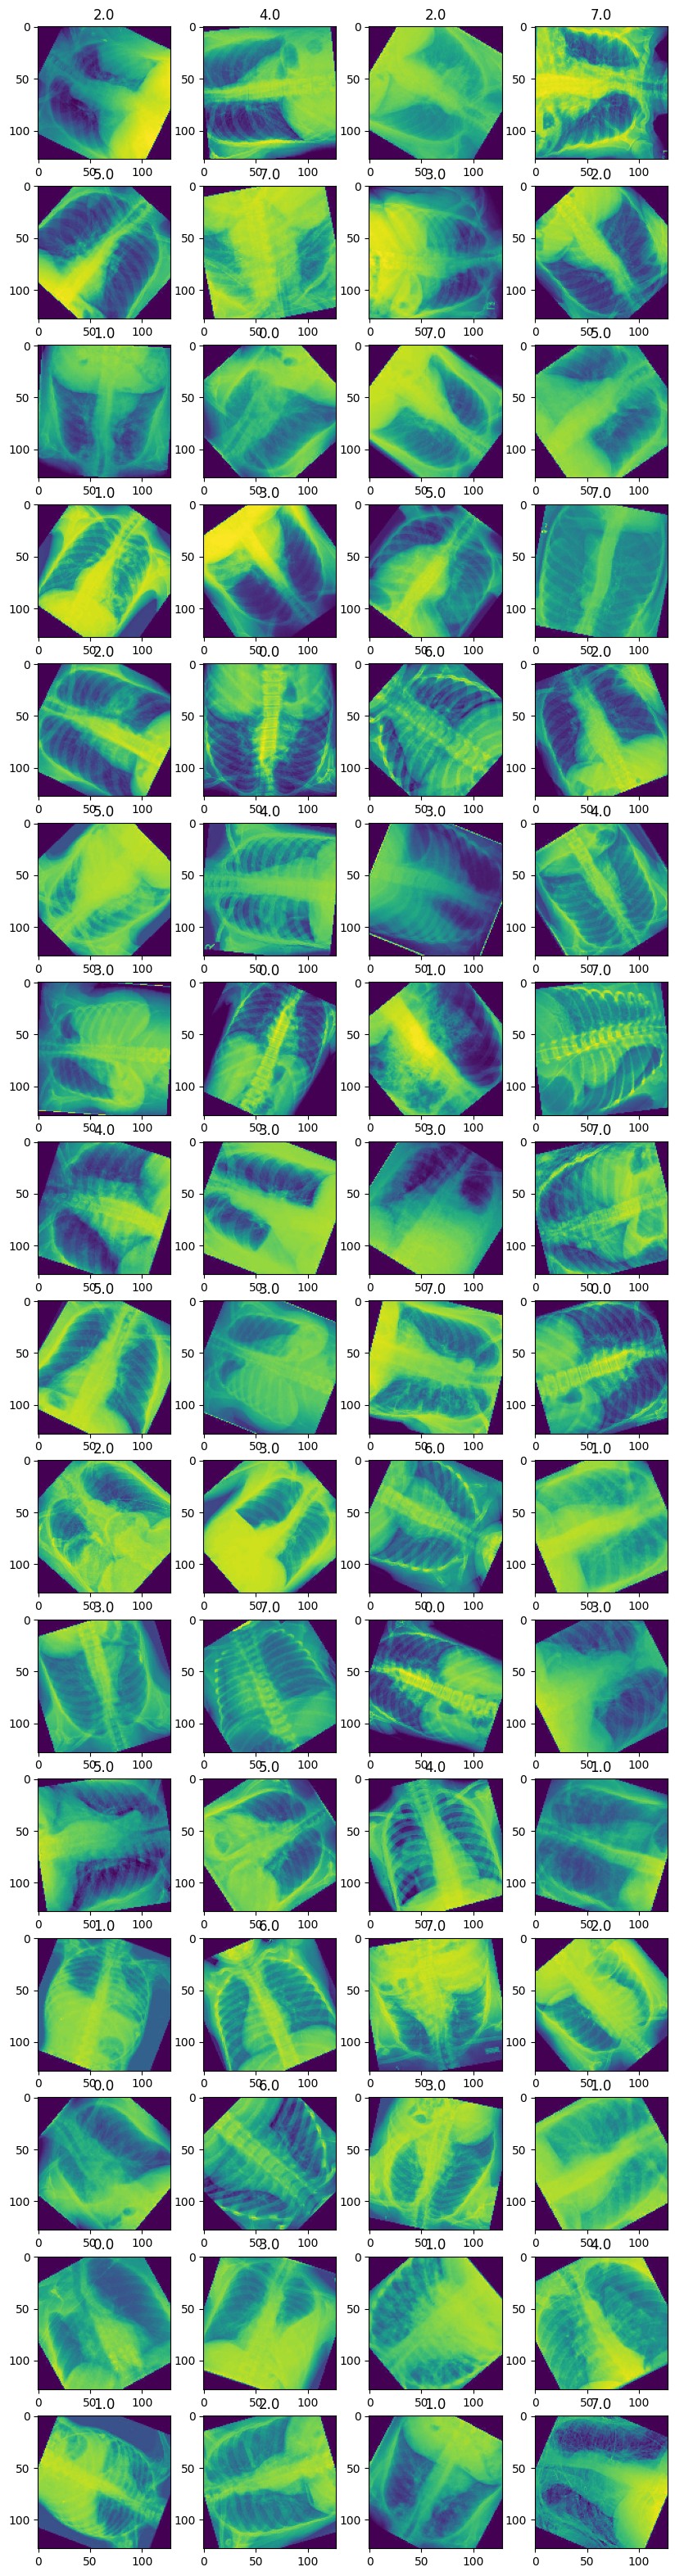

In [10]:
import matplotlib.pyplot as plt

imgs, targets = next(iter(train_generator))
fig, axes = plt.subplots(nrows=16, ncols=4, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  axes[i-16*(i//16),i//16].imshow(img)
  axes[i-16*(i//16),i//16].title.set_text(str(target))
fig.show()


# Entrainement

In [11]:
CLASSES = 8

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((128, 128, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(CLASSES, activation="softmax")
])
model.summary()

2025-01-23 20:13:50.793552: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       262,152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,648 (1.04 MB)

 Trainable params: 272,648 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [15]:
model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator)

2025/01/23 20:19:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/01/23 20:19:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3111 - loss: 1.8475

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 1030s 1s/step - accuracy: 0.3111 - loss: 1.8474 - val_accuracy: 0.3801 - val_loss: 1.7004


2025/01/23 20:36:50 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/01/23 20:36:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/01/23 20:36:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Sauvegarde du tracking MLFLOW

In [59]:
mlflow.log_param("trainer", TRAINER) 
mlflow.log_param("epochs", EPOCHS) 
mlflow.log_param("model_type", MODEL_TYPE)

# Sauvegarde du modèle
mlflow.keras.log_model(model, "model")

# Sauvegarde des métriques par époque
history = model.history
for epoch in range(len(history.history['loss'])):
    mlflow.log_metric('loss', history.history['loss'][epoch], step=epoch)
    mlflow.log_metric('accuracy', history.history['accuracy'][epoch], step=epoch)
    mlflow.log_metric('val_loss', history.history['val_loss'][epoch], step=epoch)
    mlflow.log_metric('val_accuracy', history.history['val_accuracy'][epoch], step=epoch)


2025/01/23 21:16:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/23 21:16:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KeyError: 'loss'

In [17]:
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step


In [18]:
from sklearn.metrics import classification_report, f1_score

report = classification_report(y_pred, y_true, output_dict=True)
report

{'0': {'precision': 0.39266666666666666,
  'recall': 0.5593542260208927,
  'f1-score': 0.4614179396788093,
  'support': 2106.0},
 '1': {'precision': 0.15833333333333333,
  'recall': 0.29817953546767106,
  'f1-score': 0.20683649031134335,
  'support': 1593.0},
 '2': {'precision': 0.4836666666666667,
  'recall': 0.26960237829803047,
  'f1-score': 0.3462180863755667,
  'support': 5382.0},
 '3': {'precision': 0.511,
  'recall': 0.26536264497143847,
  'f1-score': 0.3493220918309217,
  'support': 5777.0},
 '4': {'precision': 0.21266666666666667,
  'recall': 0.37157833430401865,
  'f1-score': 0.27051091795632815,
  'support': 1717.0},
 '5': {'precision': 0.503,
  'recall': 0.4468463132958247,
  'f1-score': 0.4732632899482515,
  'support': 3377.0},
 '6': {'precision': 0.55,
  'recall': 0.7124352331606217,
  'f1-score': 0.6207674943566591,
  'support': 2316.0},
 '7': {'precision': 0.225,
  'recall': 0.38972286374133946,
  'f1-score': 0.28529163144547764,
  'support': 1732.0},
 'accuracy': 0.379

In [55]:
mlflow.log_metric('global_accuracy', report['accuracy'])
mlflow.log_metric('macro_avg_precision', report['macro avg']['precision'])
mlflow.log_metric('macro_avg_recall', report['macro avg']['recall'])
mlflow.log_metric('macro_avg_f1_score', report['macro avg']['f1-score'])
mlflow.log_metric('macro_avg_support', report['macro avg']['support'])
mlflow.log_metric('weighted_avg_precision', report['weighted avg']['precision'])
mlflow.log_metric('weighted_avg_recall', report['weighted avg']['recall'])
mlflow.log_metric('weighted_avg_f1_score', report['weighted avg']['f1-score'])
mlflow.log_metric('weighted_avg_support', report['weighted avg']['support'])

In [46]:
for class_mesure in list(report.items())[:CLASSES]:
    for m_name, m_value in class_mesure[1].items():
        mlflow.log_metric(m_name, m_value, step=int(class_mesure[0]))

accuracy-precision-0.39266666666666666


accuracy-recall-0.5593542260208927
accuracy-f1-score-0.4614179396788093
accuracy-support-2106.0
accuracy-precision-0.15833333333333333
accuracy-recall-0.29817953546767106
accuracy-f1-score-0.20683649031134335
accuracy-support-1593.0
accuracy-precision-0.4836666666666667
accuracy-recall-0.26960237829803047
accuracy-f1-score-0.3462180863755667
accuracy-support-5382.0
accuracy-precision-0.511
accuracy-recall-0.26536264497143847
accuracy-f1-score-0.3493220918309217
accuracy-support-5777.0
accuracy-precision-0.21266666666666667
accuracy-recall-0.37157833430401865
accuracy-f1-score-0.27051091795632815
accuracy-support-1717.0
accuracy-precision-0.503
accuracy-recall-0.4468463132958247
accuracy-f1-score-0.4732632899482515
accuracy-support-3377.0
accuracy-precision-0.55
accuracy-recall-0.7124352331606217
accuracy-f1-score-0.6207674943566591
accuracy-support-2316.0
accuracy-precision-0.225
accuracy-recall-0.38972286374133946
accuracy-f1-score-0.28529163144547764
accuracy-support-1732.0


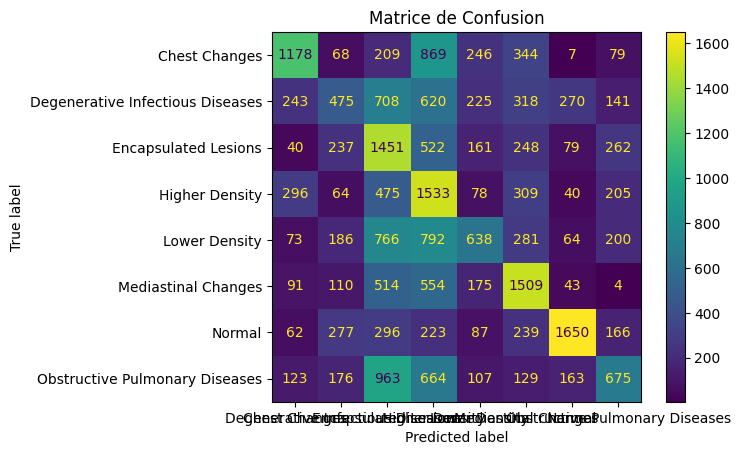

In [48]:
# Metriques à ajouter : accuracy/val accuracy par classe, précision, recall, f1score, image de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot()
plt.title("Matrice de Confusion")
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png", artifact_path='model')

In [57]:
mlflow.end_run()

🏃 View run adaptable-asp-341 at: https://david-rem-jedha-final-project-mlops.hf.space/#/experiments/1/runs/1ebab34271104ef49e0c9dbd4238d885
🧪 View experiment at: https://david-rem-jedha-final-project-mlops.hf.space/#/experiments/1
